In [14]:
from datasets import Dataset, load_dataset, concatenate_datasets
import numpy as np
from PIL import Image

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, r2_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline


In [29]:
ds = load_dataset('BingSu/Cat_and_Dog')

label_names = ds["train"].features["labels"].names

dog_label = ds['train'].filter(lambda x: x['labels'] == 1)
cat_label = ds['train'].filter(lambda x: x['labels'] == 0)

dog_label = dog_label.shuffle(seed=42).select(range(2500))
cat_label = cat_label.shuffle(seed=42).select(range(2500))

ds = concatenate_datasets([dog_label, cat_label])
ds = ds.shuffle(seed=42)

In [16]:
split = ds.train_test_split(test_size=0.2, stratify_by_column="labels", seed=42)
ds_train, ds_test = split["train"], split["test"]

In [17]:
IMG_SIZE = (128, 128)

def pil_to_vec(img_pil, size=IMG_SIZE):
    arr = np.array(
        img_pil.convert("RGB").resize(size, Image.BILINEAR),
        dtype=np.float32
    ) / 255.0

    arr = arr.flatten()

    return arr 

In [ ]:
def iter_ds_in_batches(ds, batch_size=256):
    N = ds.num_rows
    for i in range(0, N, batch_size):
        j = min(i + batch_size, N)
        chunk = ds.select(range(i, j)) 

        imgs = chunk["image"]
        ys   = np.asarray(chunk["labels"], dtype=np.int32)

        Xb = np.stack([pil_to_vec(img) for img in imgs], axis=0)
        yield Xb, ys

In [19]:
from sklearn.decomposition import IncrementalPCA

n_components = 200
batch_size   = 256
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for Xb, _ in iter_ds_in_batches(ds_train, batch_size):
    Xb = Xb.astype(np.float32, copy=False)
    ipca.partial_fit(Xb)

N_train = ds_train.num_rows
X_train_red = np.empty((N_train, n_components), dtype=np.float32)
y_train     = np.empty((N_train,),            dtype=np.int32)

ptr = 0
for Xb, yb in iter_ds_in_batches(ds_train, batch_size):
    Xb = Xb.astype(np.float32, copy=False)
    Zb = ipca.transform(Xb).astype(np.float32)
    B  = Zb.shape[0]
    X_train_red[ptr:ptr+B] = Zb
    y_train[ptr:ptr+B]     = yb
    ptr += B

N_test = ds_test.num_rows
X_test_red = np.empty((N_test, n_components), dtype=np.float32)
y_test     = np.empty((N_test,),            dtype=np.int32)

ptr = 0
for Xb, yb in iter_ds_in_batches(ds_test, batch_size):
    Xb = Xb.astype(np.float32, copy=False)
    Zb = ipca.transform(Xb).astype(np.float32)
    B  = Zb.shape[0]
    X_test_red[ptr:ptr+B] = Zb
    y_test[ptr:ptr+B]     = yb
    ptr += B

In [20]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'svm__C':[0.01, 0.1, 1.0],
    'svm__kernel':['linear', 'poly', 'sigmoid', 'rbf'],
    'svm__degree':[1, 2, 3],
    'svm__gamma':['auto', 'scale'],
    'svm__coef0':[0.0, 1.0]
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

grid.fit(X_train_red, y_train)

/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/meu1404/miniforge/

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svm__C': [0.01, 0.1, ...], 'svm__coef0': [0.0, 1.0], 'svm__degree': [1, 2, ...], 'svm__gamma': ['auto', 'scale'], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [27]:
print('best param:', grid.best_params_)
print('best accuracy score:', grid.best_score_)



best param: {'svm__C': 1.0, 'svm__coef0': 0.0, 'svm__degree': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
best accuracy score: 0.63575


In [31]:
y_pred_np = grid.predict(X_test_red)

y_true = y_test.astype(np.int32)
y_pred =y_pred_np.astype(np.int32)

y_score = None
try:
    s = grid.decision_function(X_test_red)
    y_score = s.reshape(-1)
except Exception:
    try:
        proba = clf.predict_proba(X_test_red)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            y_score = proba[:, 1].astype(np.float32)
    except Exception:
        y_score = None


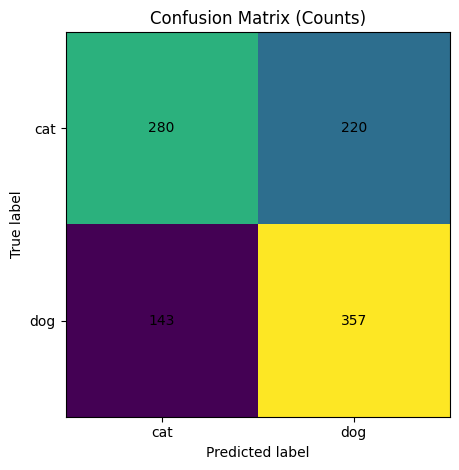

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], label_names[:2])
plt.yticks([0,1], label_names[:2])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()


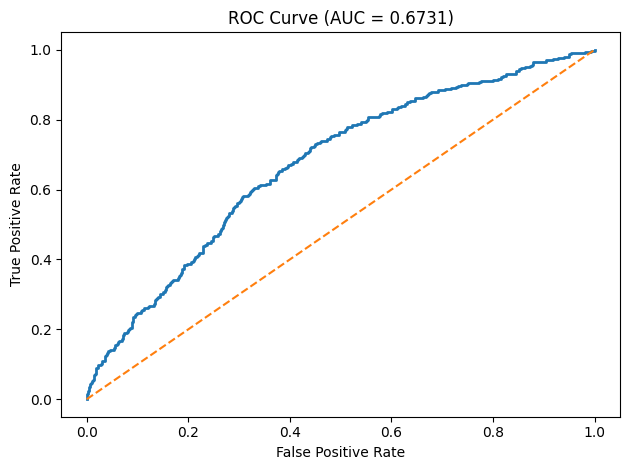

In [33]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

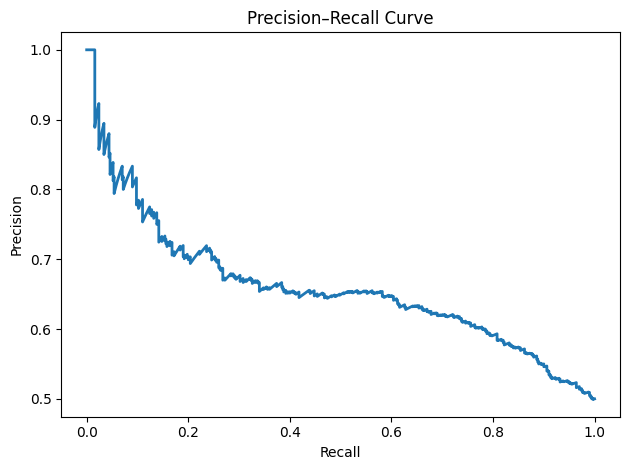

In [34]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)

plt.figure()
plt.plot(recall, precision, linewidth=2)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

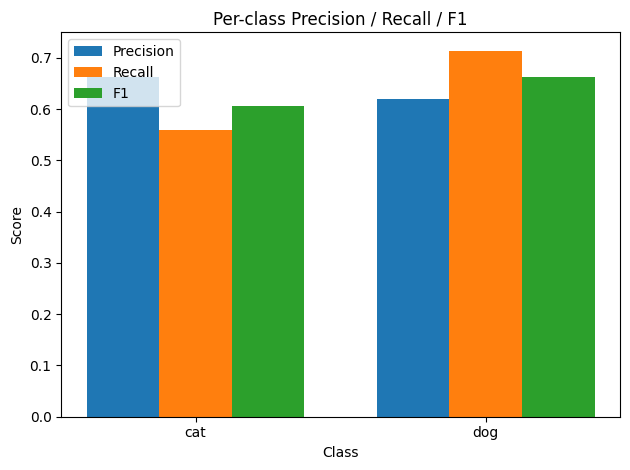

Classification report:

              precision    recall  f1-score   support

           0     0.6619    0.5600    0.6067       500
           1     0.6187    0.7140    0.6630       500

    accuracy                         0.6370      1000
   macro avg     0.6403    0.6370    0.6348      1000
weighted avg     0.6403    0.6370    0.6348      1000



In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
classes = [k for k in report.keys() if k.isdigit()]
prec = [report[c]["precision"] for c in classes]
rec  = [report[c]["recall"] for c in classes]
f1   = [report[c]["f1-score"] for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure()
plt.bar(x - width, prec, width, label="Precision")
plt.bar(x,         rec,  width, label="Recall")
plt.bar(x + width, f1,   width, label="F1")
plt.xticks(x, [label_names[int(c)] if int(c) < len(label_names) else c for c in classes])
plt.title("Per-class Precision / Recall / F1")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

print("Classification report:\n")
print(classification_report(y_true, y_pred, digits=4))